# Data Collecting and Importing Library

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from flaml import AutoML
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score

In [3]:
df_r = pd.read_csv('regressi.csv')
df_k = pd.read_csv('klasifikasi.csv')

In [4]:
df_r.head()

Square_Footage  Num_Bedrooms  Num_Bathrooms  Year_Built  Lot_Size  \
0            1360             2              1        1981  0.599637   
1            4272             3              3        2016  4.753014   
2            3592             1              2        2016  3.634823   
3             966             1              2        1977  2.730667   
4            4926             2              1        1993  4.699073   

   Garage_Size  Neighborhood_Quality   House_Price  
0            0                     5  2.623829e+05  
1            1                     6  9.852609e+05  
2            0                     9  7.779774e+05  
3            1                     8  2.296989e+05  
4            0                     8  1.041741e+06

In [5]:
df_k.head()

age  gender  impluse  pressurehight  pressurelow  glucose    kcm  troponin  \
0   64       1       66            160           83    160.0   1.80     0.012   
1   21       1       94             98           46    296.0   6.75     1.060   
2   55       1       64            160           77    270.0   1.99     0.003   
3   64       1       70            120           55    270.0  13.87     0.122   
4   55       1       64            112           65    300.0   1.08     0.003   

      class  
0  negative  
1  positive  
2  negative  
3  positive  
4  negative

# Klasifikasi

## EDA

In [6]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            1319 non-null   int64  
 1   gender         1319 non-null   int64  
 2   impluse        1319 non-null   int64  
 3   pressurehight  1319 non-null   int64  
 4   pressurelow    1319 non-null   int64  
 5   glucose        1319 non-null   float64
 6   kcm            1319 non-null   float64
 7   troponin       1319 non-null   float64
 8   class          1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [7]:
df_k.isna().sum().sum()

0

In [8]:
df_k.duplicated().sum()

0

In [10]:
cv_total = []
cv_vb = []
cv_vk = []
col = df_k.select_dtypes(include='number').columns.tolist()
for i in col:
    cv = (df_k[i].std()/df_k[i].mean())*100
    cv_total.append(cv)
    if abs(cv)>25:
        print(f"Hasil %CV {i}: {cv} Varietas sangat besar")
        cv_vb.append(cv)
    else:
        print(f"Hasil %CV {i}: {cv}")
        cv_vk.append(cv)
print(f"rata rata cv: {np.nanmean(cv_total)}")
print(f"max: {np.nanmax(cv_total)}")
print(f"Total CV dengan varietas sangat besar: {len(cv_vb)}")
print(f"Total CV dengan varietas normal: {len(cv_vk)}")

Hasil %CV age: 24.28701797556286
Hasil %CV gender: 71.8667883007869 Varietas sangat besar
Hasil %CV impluse: 65.90821878221495 Varietas sangat besar
Hasil %CV pressurehight: 20.5414803331712
Hasil %CV pressurelow: 19.418971256738903
Hasil %CV glucose: 51.095154458176495 Varietas sangat besar
Hasil %CV kcm: 303.300750658426 Varietas sangat besar
Hasil %CV troponin: 319.875893495957 Varietas sangat besar
rata rata cv: 109.53678440762928
max: 319.875893495957
Total CV dengan varietas sangat besar: 5
Total CV dengan varietas normal: 3


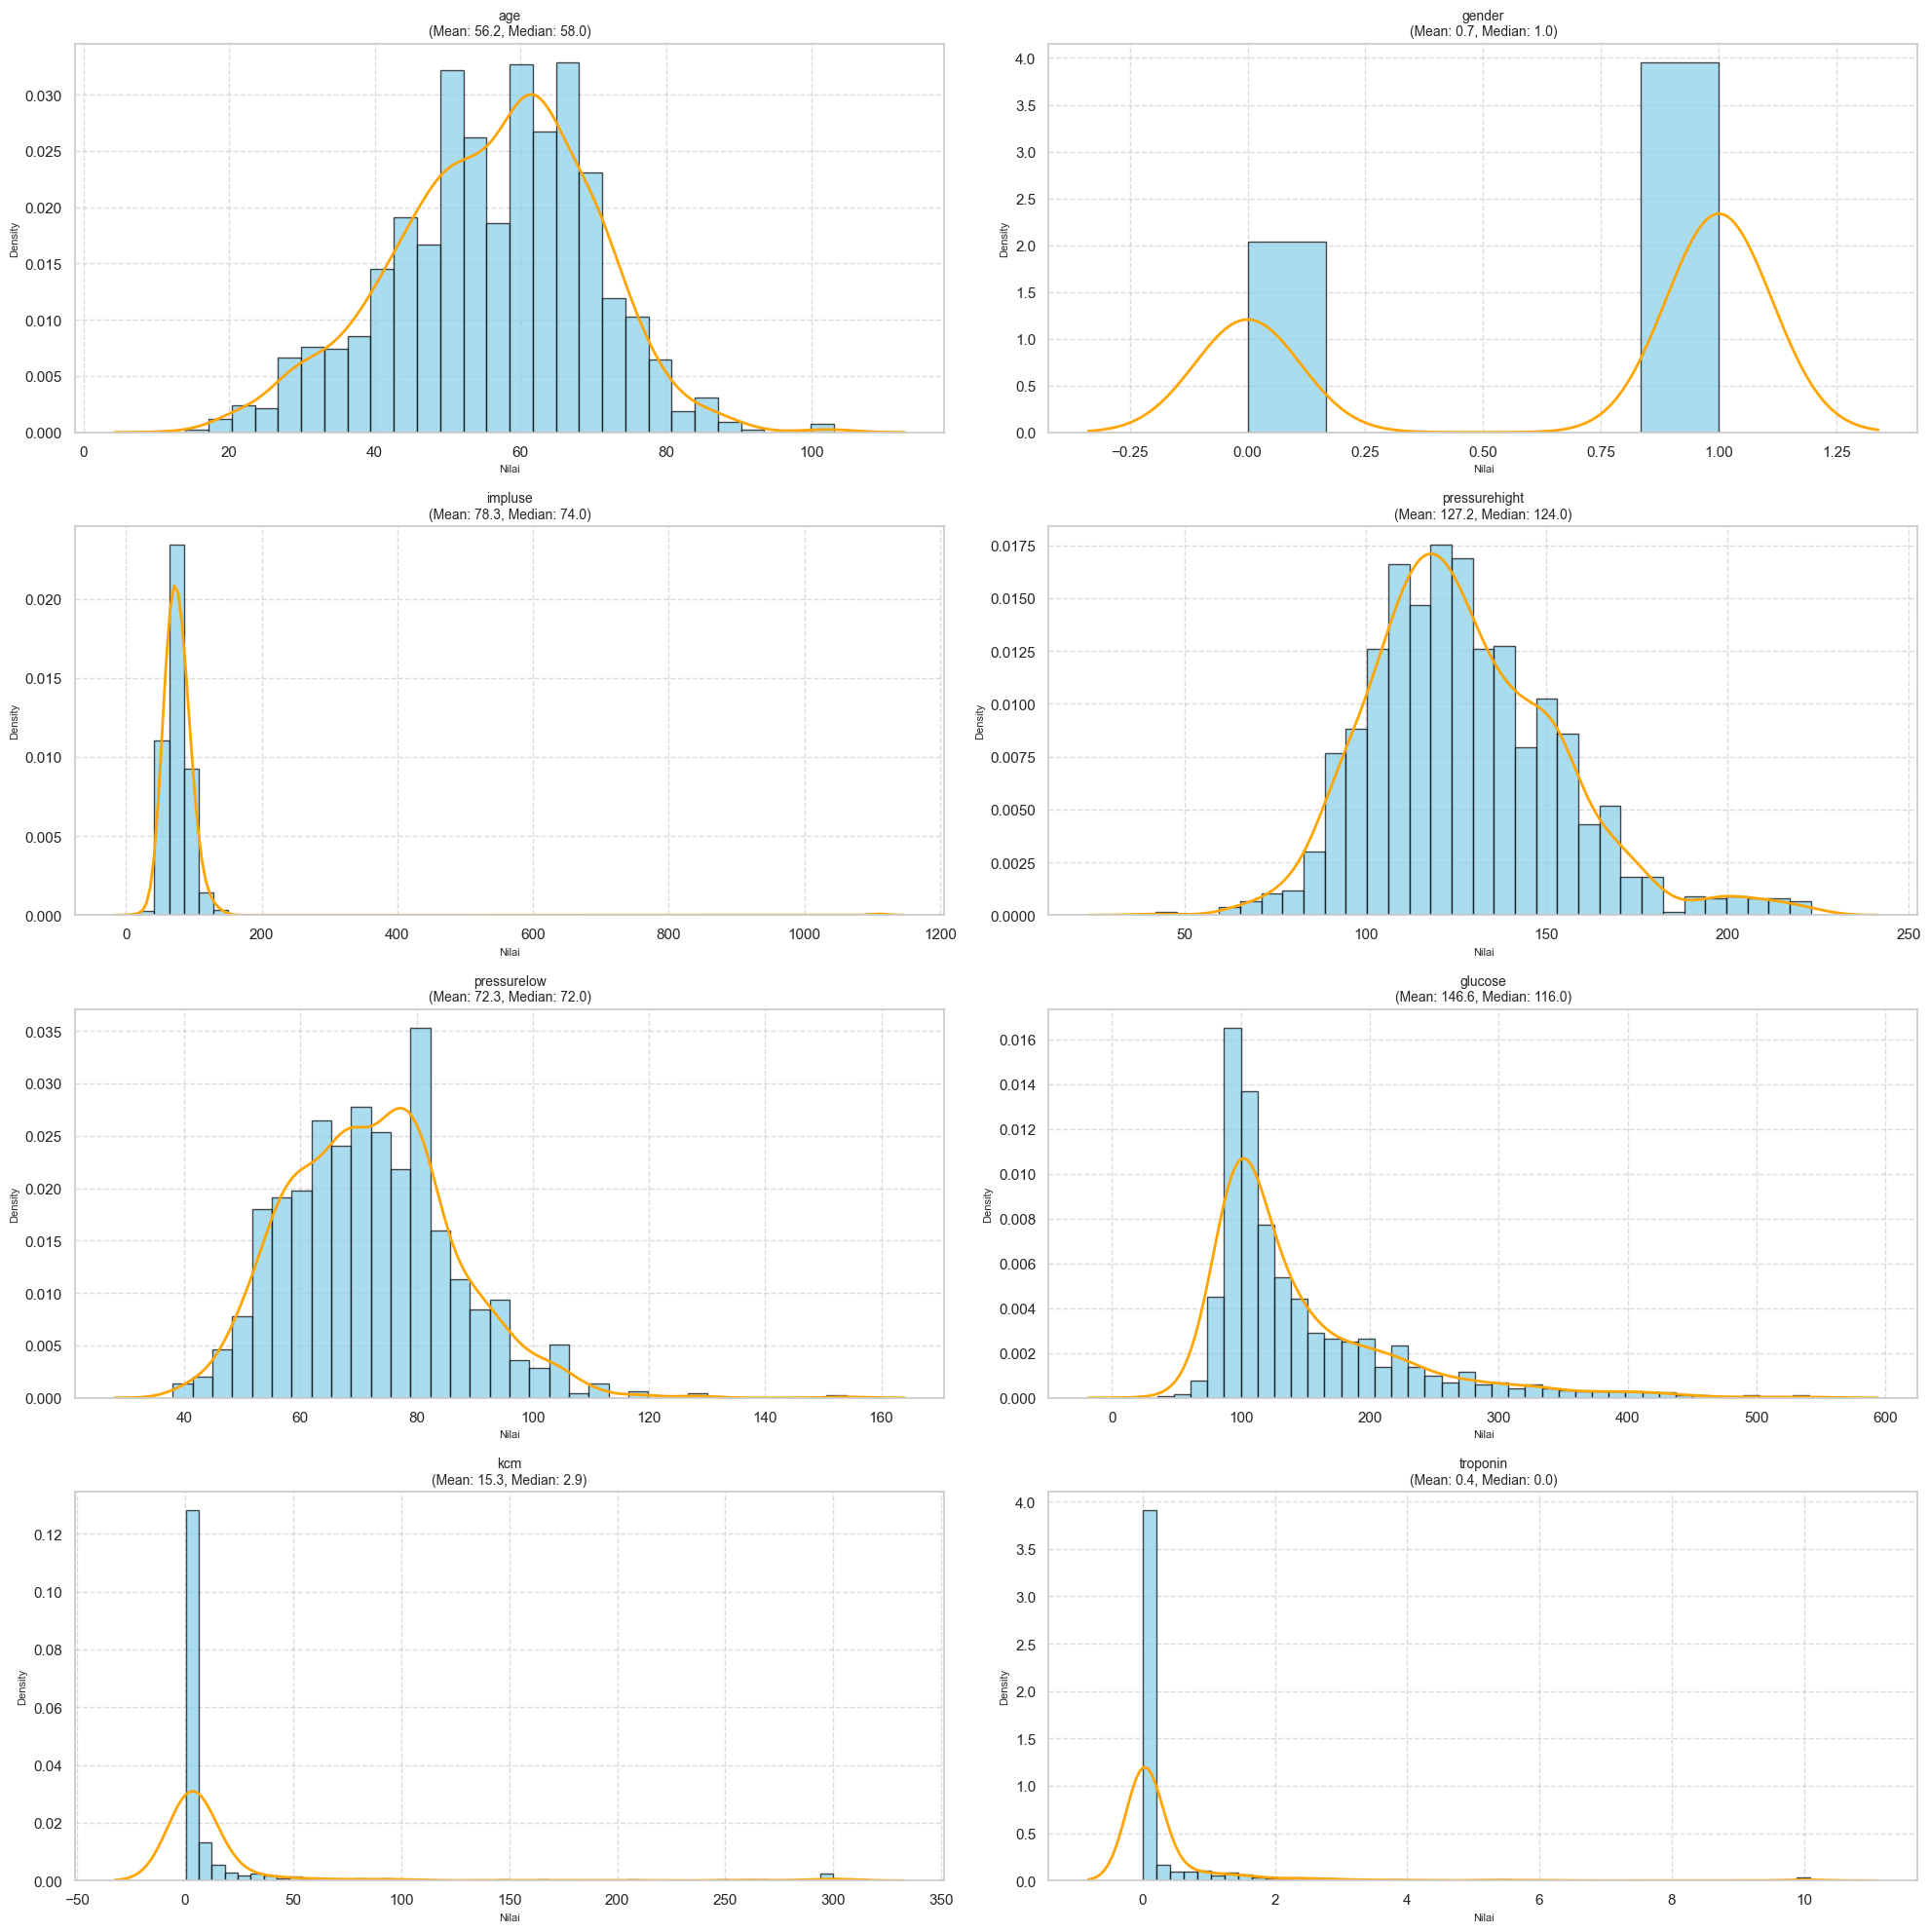

In [13]:
sns.set_theme(style='whitegrid')
numerical_cols = df_k.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df_k[col].dropna()
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    bin_width = (2 * iqr) / (len(data) ** (1/3))
    bin_count = int(np.ceil((data.max() - data.min()) / bin_width)) if iqr > 0 else 50
    
    axis.hist(
        data, 
        bins=min(bin_count, 50),  
        color='skyblue', 
        edgecolor='black',
        alpha=0.7,
        density=True  
    )
    
    sns.kdeplot(data, ax=axis, color='orange', linewidth=2)
    
    axis.set_title(f'{col}\n(Mean: {data.mean():.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_xlabel('Nilai', fontsize=8)
    axis.set_ylabel('Density', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    if len(col) > 15:
        axis.tick_params(axis='x', rotation=45)

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

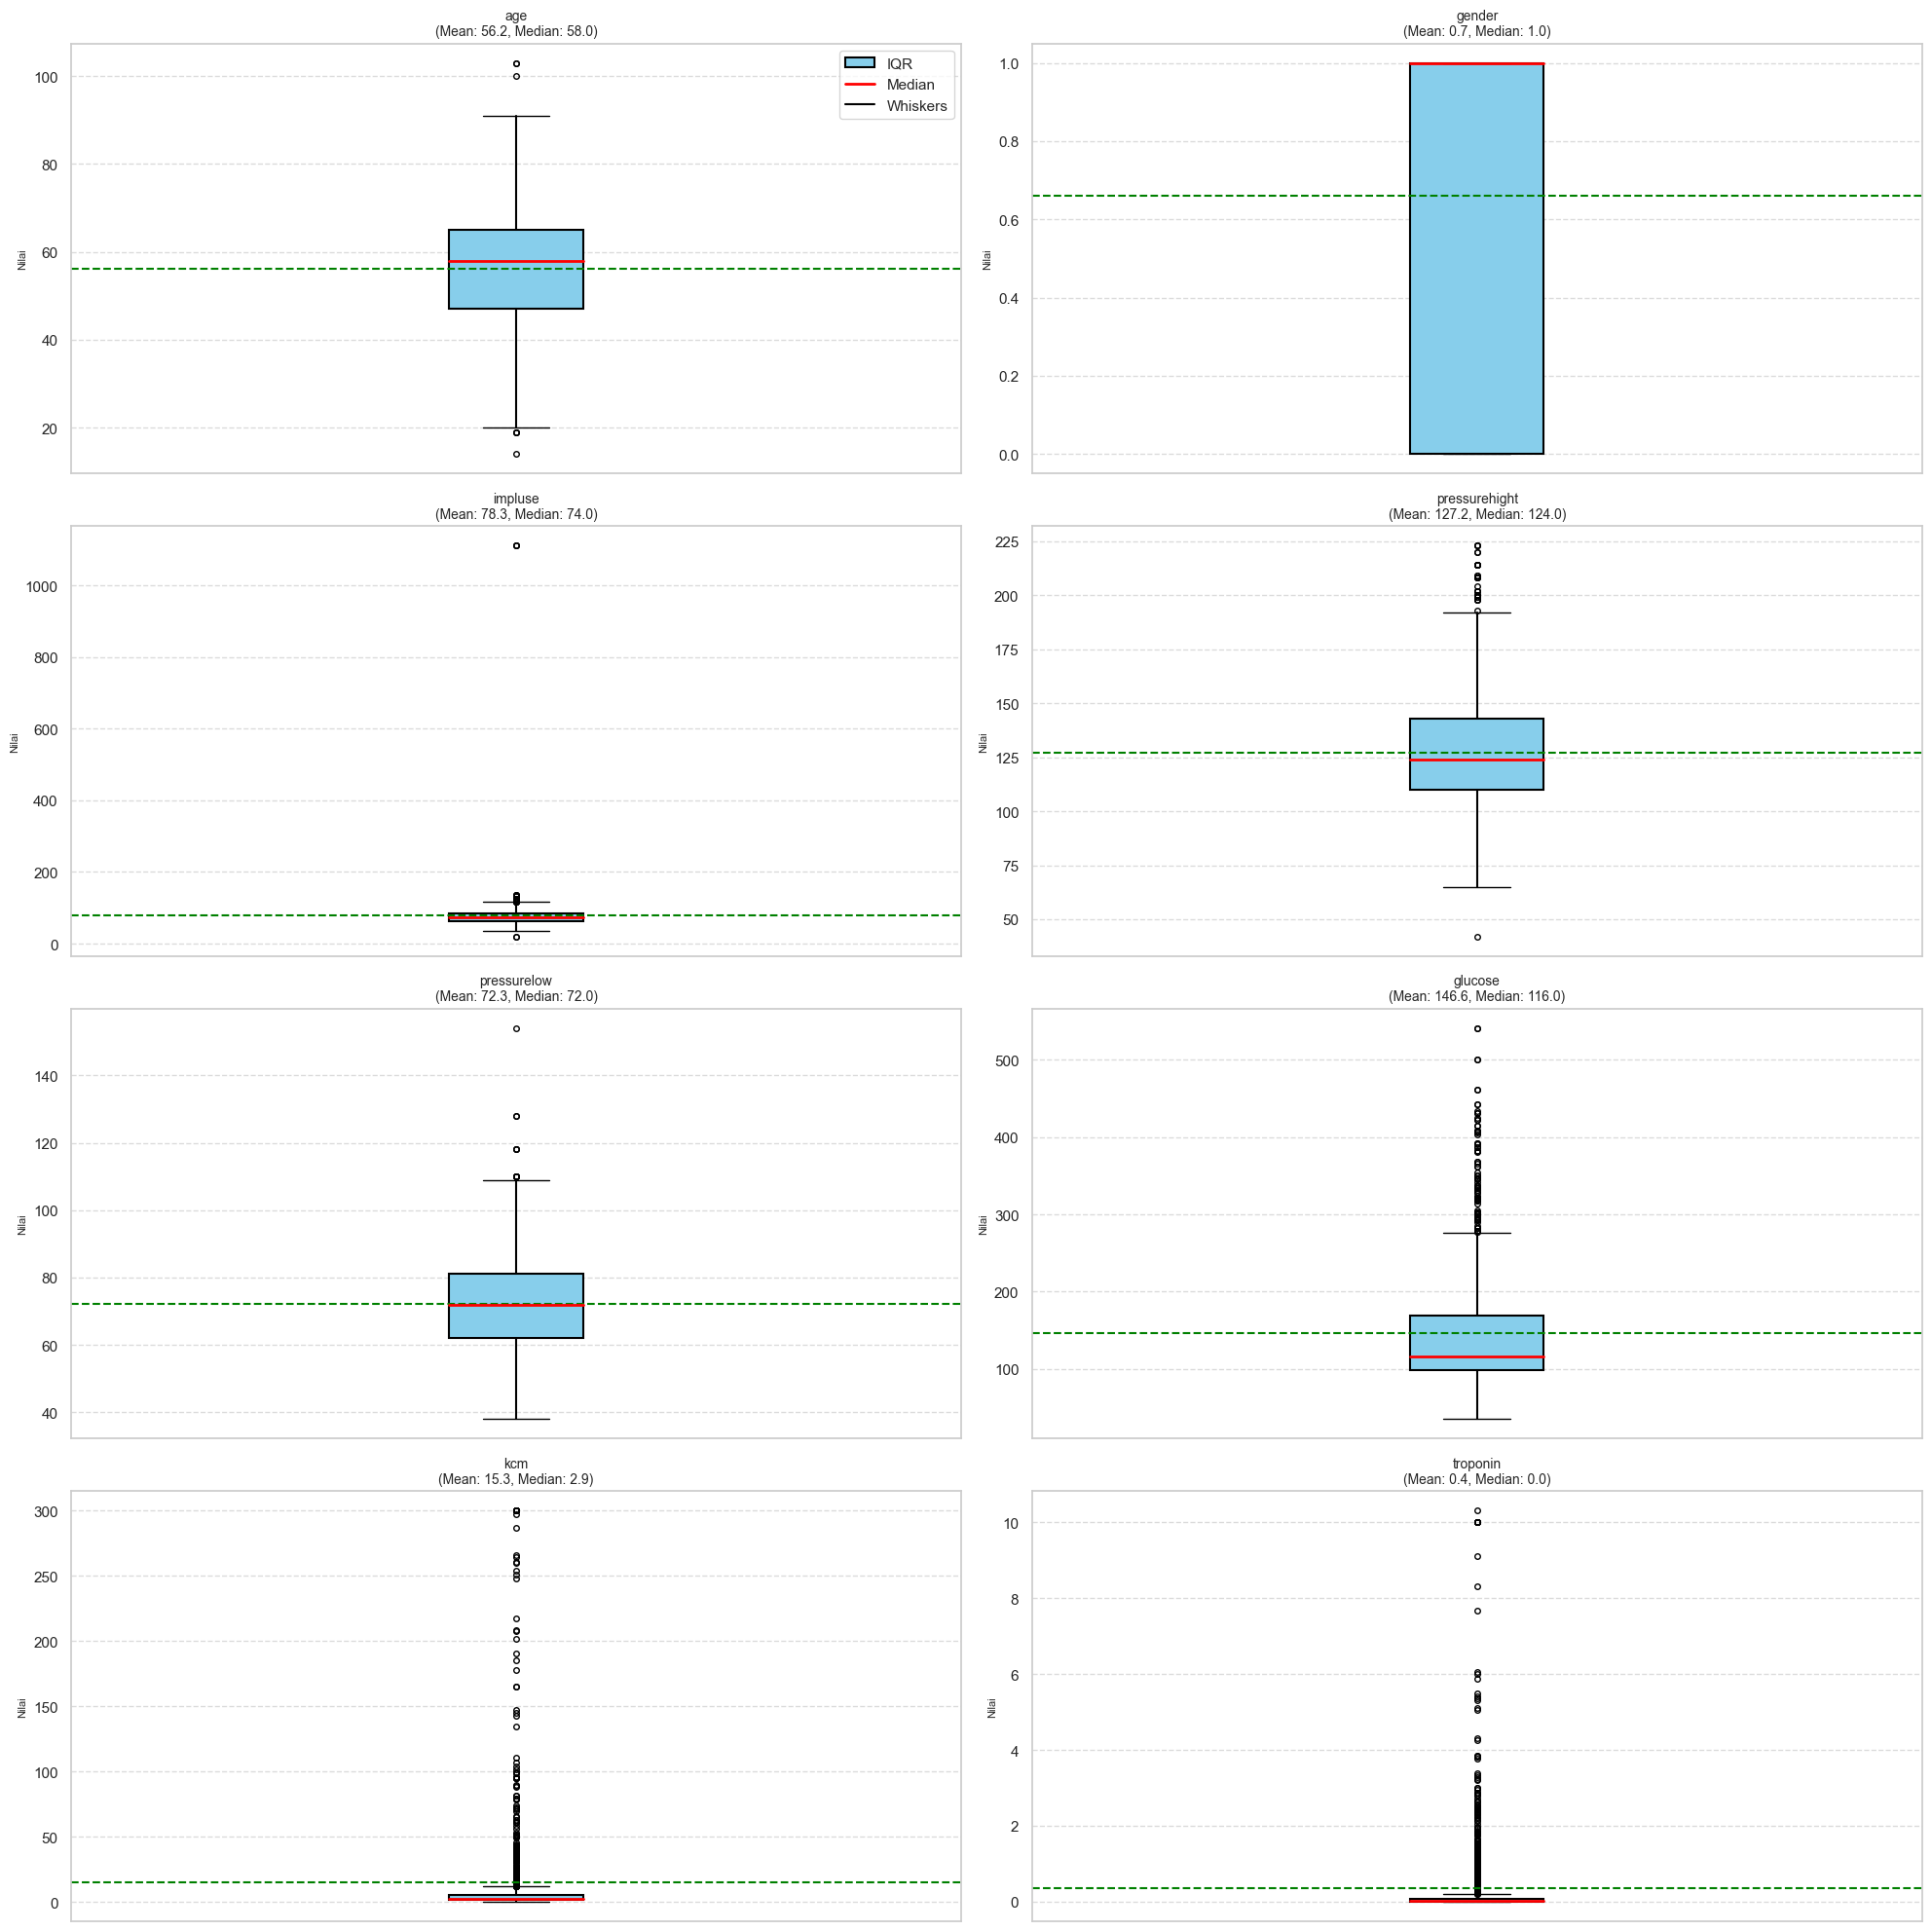

In [14]:
sns.set_theme(style='whitegrid')
numerical_cols = df_k.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df_k[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

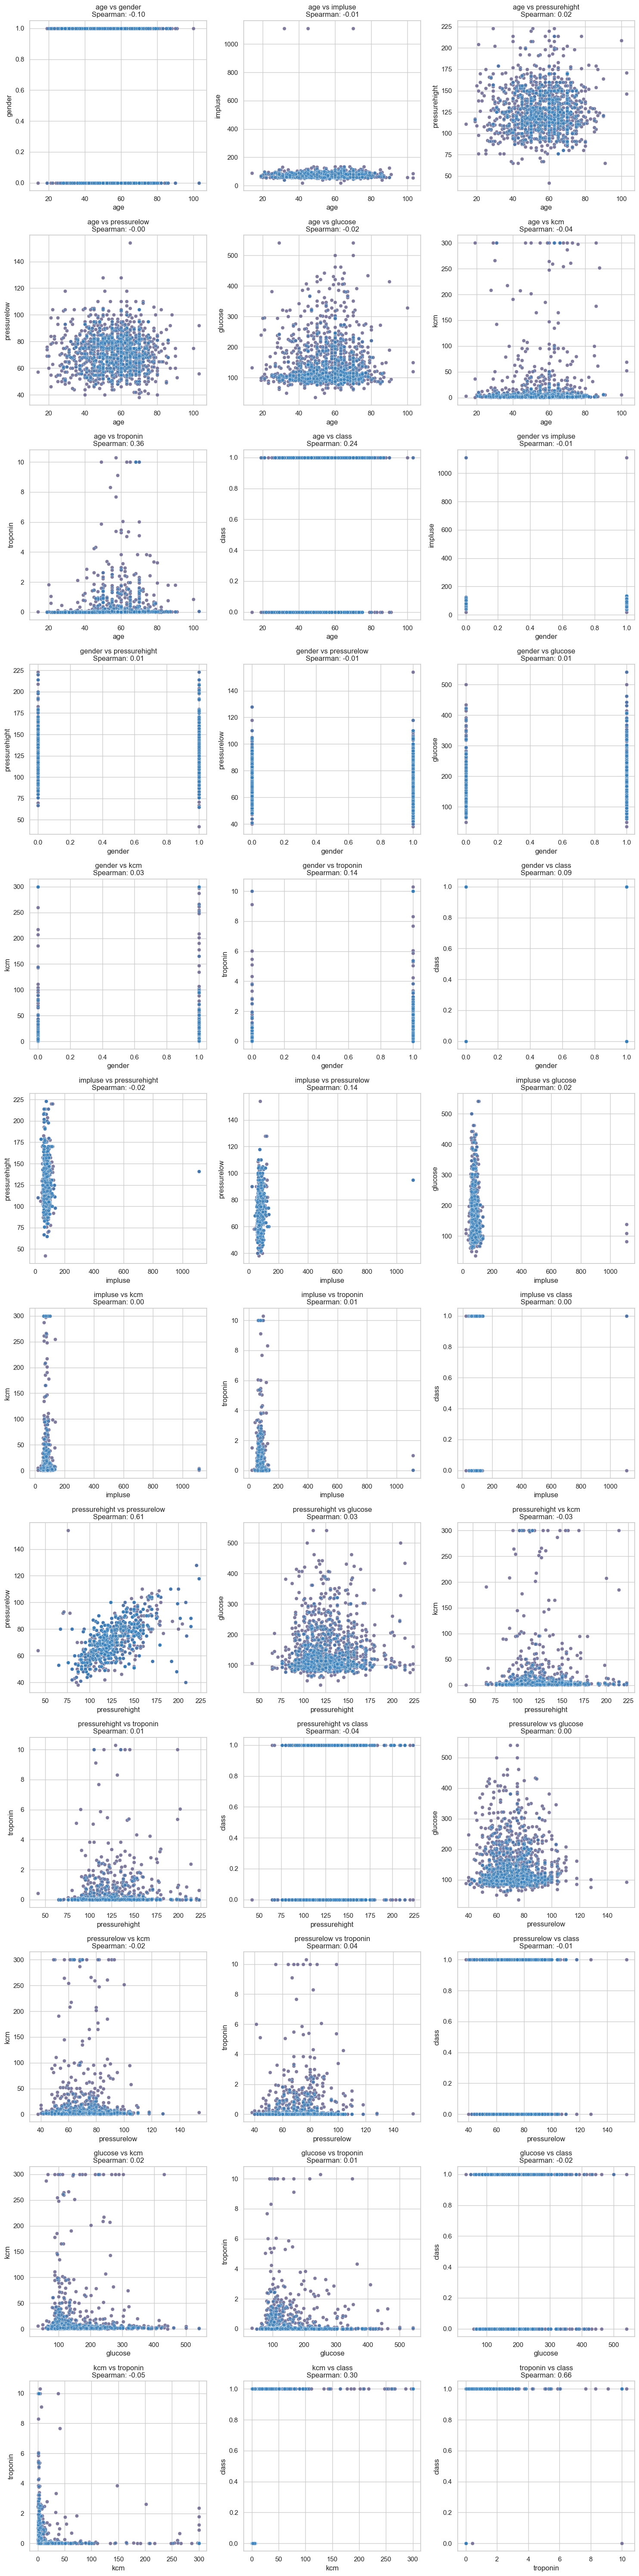

In [44]:
num_cols = df_k.select_dtypes(include='number').columns.tolist()
spearman_corr = df_k[num_cols].corr(method='spearman')
comb = list(combinations(num_cols, 2))

n_comb = len(comb)
rows = int(np.ceil(n_comb / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

colors = sns.color_palette("Set1", 2)

for i, (col_x, col_y) in enumerate(comb):
    ax = axes[i]
    sns.scatterplot(x=df_k[col_x], y=df_k[col_y], ax=ax, alpha=0.6, color=colors[0])
    sns.scatterplot(x=df_k[col_x], y=df_k[col_y], ax=ax, alpha=0.6, color=colors[1])
    rho = spearman_corr.loc[col_x, col_y]
    ax.set_title(f"{col_x} vs {col_y}\nSpearman: {rho:.2f}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [17]:
df_k['class'].value_counts()

class
positive    810
negative    509
Name: count, dtype: int64

In [21]:
le = LabelEncoder()

df_k['class'] = le.fit_transform(df_k['class'])
df_k.head()

age  gender  impluse  pressurehight  pressurelow  glucose    kcm  troponin  \
0   64       1       66            160           83    160.0   1.80     0.012   
1   21       1       94             98           46    296.0   6.75     1.060   
2   55       1       64            160           77    270.0   1.99     0.003   
3   64       1       70            120           55    270.0  13.87     0.122   
4   55       1       64            112           65    300.0   1.08     0.003   

   class  
0      0  
1      1  
2      0  
3      1  
4      0

In [25]:
x_k = df_k.drop(columns=['class'])
y_k = df_k['class']

In [26]:
mm = MinMaxScaler()

x_k = pd.DataFrame(mm.fit_transform(x_k), columns=x_k.columns)
x_k.describe()

age       gender      impluse  pressurehight  pressurelow  \
count  1319.000000  1319.000000  1319.000000    1319.000000  1319.000000   
mean      0.474065     0.659591     0.053471       0.470556     0.295424   
std       0.153341     0.474027     0.047324       0.144324     0.120982   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%       0.370787     0.000000     0.040330       0.375691     0.206897   
50%       0.494382     1.000000     0.049496       0.453039     0.293103   
75%       0.573034     1.000000     0.059578       0.558011     0.370690   
max       1.000000     1.000000     1.000000       1.000000     1.000000   

           glucose          kcm     troponin  
count  1319.000000  1319.000000  1319.000000  
mean      0.220621     0.049898     0.034949  
std       0.148069     0.154589     0.112105  
min       0.000000     0.000000     0.000000  
25%       0.124506     0.004451     0.000485  
50%       0.160079     0.008439     0.001262  
75%       0.265810     0.018300     0.008205  
max       1.000000     1.000000     1.000000

In [31]:
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(x_k, y_k, test_size=0.2, random_state=42)

## Modelling

In [32]:
automl = AutoML()
settings = {
    "time_budget" :10*60,
    "metric" : 'accuracy',
    "task" : 'classification',
    "log_file_name": "automl_classification.log"
}
automl.fit(X_train=x_train_k, y_train=y_train_k, **settings)

[flaml.automl.logger: 06-14 21:44:32] {1752} INFO - task = classification
[flaml.automl.logger: 06-14 21:44:32] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 06-14 21:44:32] {1862} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-14 21:44:34] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 06-14 21:44:34] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-14 21:44:34] {2417} INFO - Estimated sufficient time budget=1137s. Estimated necessary time budget=28s.
[flaml.automl.logger: 06-14 21:44:34] {2466} INFO -  at 1.3s,	estimator lgbm's best error=0.0218,	best estimator lgbm's best error=0.0218
[flaml.automl.logger: 06-14 21:44:34] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-14 21:44:34] {2466} INFO -  at 1.4s,	estimator lgbm's best error=0.0218,	best estimator lgbm's best error=0.0218
[flaml.automl.l

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:34] {2466} INFO -  at 121.8s,	estimator lrl1's best error=0.2076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:34] {2282} INFO - iteration 257, current learner lrl1
[flaml.automl.logger: 06-14 21:46:34] {2466} INFO -  at 121.9s,	estimator lrl1's best error=0.1934,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:34] {2282} INFO - iteration 258, current learner rf


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:35] {2466} INFO -  at 122.2s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 259, current learner lrl1
[flaml.automl.logger: 06-14 21:46:35] {2466} INFO -  at 122.3s,	estimator lrl1's best error=0.1934,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 260, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:35] {2466} INFO -  at 122.6s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 261, current learner lrl1
[flaml.automl.logger: 06-14 21:46:35] {2466} INFO -  at 122.7s,	estimator lrl1's best error=0.1896,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 262, current learner sgd
[flaml.automl.logger: 06-14 21:

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 263, current learner lrl1
[flaml.automl.logger: 06-14 21:46:35] {2466} INFO -  at 122.9s,	estimator lrl1's best error=0.1896,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:35] {2282} INFO - iteration 264, current learner xgb_limitdepth


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:36] {2466} INFO -  at 123.3s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:36] {2282} INFO - iteration 265, current learner sgd
[flaml.automl.logger: 06-14 21:46:36] {2466} INFO -  at 123.3s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:36] {2282} INFO - iteration 266, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:36] {2466} INFO -  at 123.5s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:36] {2282} INFO - iteration 267, current learner sgd
[flaml.automl.logger: 06-14 21:46:36] {2466} INFO -  at 123.6s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:36] {2282} INFO - iteration 268, current learner sgd
[flaml.automl.logger: 0

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:38] {2466} INFO -  at 126.0s,	estimator catboost's best error=0.0095,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:38] {2282} INFO - iteration 273, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:39] {2466} INFO -  at 126.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:39] {2282} INFO - iteration 274, current learner sgd
[flaml.automl.logger: 06-14 21:46:39] {2466} INFO -  at 126.4s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:39] {2282} INFO - iteration 275, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:39] {2466} INFO -  at 126.6s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:39] {2282} INFO - iteration 276, current learner xgb_limitde

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:42] {2466} INFO -  at 129.2s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:42] {2282} INFO - iteration 285, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:42] {2466} INFO -  at 129.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:42] {2282} INFO - iteration 286, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:42] {2466} INFO -  at 129.8s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:42] {2282} INFO - iteration 287, current learner sgd
[flaml.automl.logger: 06-14 21:46:42] {2466} INFO -  at 129.8s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:42] {2282} INFO - iteration 288, current learner catboost


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:46] {2466} INFO -  at 133.7s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:46] {2282} INFO - iteration 292, current learner extra_tree
[flaml.automl.logger: 06-14 21:46:47] {2466} INFO -  at 134.5s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:47] {2282} INFO - iteration 293, current learner sgd
[flaml.automl.logger: 06-14 21:46:47] {2466} INFO -  at 134.5s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:47] {2282} INFO - iteration 294, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:46:47] {2466} INFO -  at 134.7s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:47] {2282} INFO - iteration 295, current learner sgd
[flaml.automl

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:46:50] {2466} INFO -  at 137.9s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:50] {2282} INFO - iteration 308, current learner sgd
[flaml.automl.logger: 06-14 21:46:50] {2466} INFO -  at 138.0s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:50] {2282} INFO - iteration 309, current learner catboost
[flaml.automl.logger: 06-14 21:46:54] {2466} INFO -  at 141.4s,	estimator catboost's best error=0.0095,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:54] {2282} INFO - iteration 310, current learner sgd
[flaml.automl.logger: 06-14 21:46:54] {2466} INFO -  at 141.4s,	estimator sgd's best error=0.2464,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:46:54] {2282} INFO - iteration 311, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:47:23] {2466} INFO -  at 170.3s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:23] {2282} INFO - iteration 369, current learner rf
[flaml.automl.logger: 06-14 21:47:23] {2466} INFO -  at 170.5s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:23] {2282} INFO - iteration 370, current learner catboost
[flaml.automl.logger: 06-14 21:47:25] {2466} INFO -  at 172.8s,	estimator catboost's best error=0.0095,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:25] {2282} INFO - iteration 371, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:47:25] {2466} INFO -  at 173.0s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:25] {2282} INFO - iteration 372, current learner lrl1
[flaml.automl.logg

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:47:26] {2466} INFO -  at 173.5s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:26] {2282} INFO - iteration 374, current learner lrl1
[flaml.automl.logger: 06-14 21:47:26] {2466} INFO -  at 173.6s,	estimator lrl1's best error=0.1886,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:26] {2282} INFO - iteration 375, current learner xgb_limitdepth


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:47:26] {2466} INFO -  at 173.9s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:26] {2282} INFO - iteration 376, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:47:27] {2466} INFO -  at 174.1s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:27] {2282} INFO - iteration 377, current learner rf
[flaml.automl.logger: 06-14 21:47:27] {2466} INFO -  at 174.6s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:27] {2282} INFO - iteration 378, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:47:27] {2466} INFO -  at 174.8s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:27] {2282} INFO - iteration 379, current learner rf
[fla

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:47:34] {2466} INFO -  at 181.6s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:34] {2282} INFO - iteration 392, current learner extra_tree
[flaml.automl.logger: 06-14 21:47:35] {2466} INFO -  at 182.2s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:35] {2282} INFO - iteration 393, current learner extra_tree
[flaml.automl.logger: 06-14 21:47:35] {2466} INFO -  at 183.0s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:35] {2282} INFO - iteration 394, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:47:36] {2466} INFO -  at 183.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:47:36] {2282} INFO - iteration 395, current learner xgb

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:50:56] {2466} INFO -  at 383.9s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:50:56] {2282} INFO - iteration 463, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:50:56] {2466} INFO -  at 384.1s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:50:56] {2282} INFO - iteration 464, current learner sgd
[flaml.automl.logger: 06-14 21:50:57] {2466} INFO -  at 384.1s,	estimator sgd's best error=0.1810,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:50:57] {2282} INFO - iteration 465, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:50:57] {2466} INFO -  at 384.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:50:57] {2282} INFO - iteration 466, current learner extra

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:51:02] {2466} INFO -  at 389.3s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:51:02] {2282} INFO - iteration 476, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:51:02] {2466} INFO -  at 389.6s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:51:02] {2282} INFO - iteration 477, current learner extra_tree
[flaml.automl.logger: 06-14 21:51:03] {2466} INFO -  at 390.3s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:51:03] {2282} INFO - iteration 478, current learner sgd
[flaml.automl.logger: 06-14 21:51:03] {2466} INFO -  at 390.4s,	estimator sgd's best error=0.1810,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:51:03] {2282} INFO - iteration 479, current learner xgb_limitdepth
[f

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:53:13] {2466} INFO -  at 520.5s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:13] {2282} INFO - iteration 529, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:13] {2466} INFO -  at 520.7s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:13] {2282} INFO - iteration 530, current learner lrl1
[flaml.automl.logger: 06-14 21:53:13] {2466} INFO -  at 520.9s,	estimator lrl1's best error=0.1886,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:13] {2282} INFO - iteration 531, current learner sgd
[flaml.automl.logger: 06-14 21:53:13] {2466} INFO -  at 520.9s,	estimator sgd's best error=0.1810,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:13] {2282} INFO - iteration 532, current learner xgb_limitdepth


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:53:14] {2466} INFO -  at 521.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:14] {2282} INFO - iteration 533, current learner rf
[flaml.automl.logger: 06-14 21:53:14] {2466} INFO -  at 521.6s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:14] {2282} INFO - iteration 534, current learner rf
[flaml.automl.logger: 06-14 21:53:14] {2466} INFO -  at 521.9s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:14] {2282} INFO - iteration 535, current learner rf
[flaml.automl.logger: 06-14 21:53:15] {2466} INFO -  at 522.1s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:15] {2282} INFO - iteration 536, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:15] {2

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:53:15] {2466} INFO -  at 523.0s,	estimator rf's best error=0.0085,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:15] {2282} INFO - iteration 540, current learner lrl1
[flaml.automl.logger: 06-14 21:53:15] {2466} INFO -  at 523.1s,	estimator lrl1's best error=0.1877,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:15] {2282} INFO - iteration 541, current learner xgb_limitdepth


d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:53:16] {2466} INFO -  at 523.3s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:16] {2282} INFO - iteration 542, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:16] {2466} INFO -  at 523.8s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:16] {2282} INFO - iteration 543, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:16] {2466} INFO -  at 523.9s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:16] {2282} INFO - iteration 544, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:17] {2466} INFO -  at 524.2s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:17] {2282} INFO - iteration 545,

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:53:21] {2466} INFO -  at 528.4s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:21] {2282} INFO - iteration 558, current learner extra_tree
[flaml.automl.logger: 06-14 21:53:22] {2466} INFO -  at 529.2s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:22] {2282} INFO - iteration 559, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:22] {2466} INFO -  at 529.4s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:22] {2282} INFO - iteration 560, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:53:22] {2466} INFO -  at 529.6s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:53:22] {2282} INFO - iteration 561, current lea

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:54:02] {2466} INFO -  at 569.5s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:02] {2282} INFO - iteration 625, current learner rf
[flaml.automl.logger: 06-14 21:54:02] {2466} INFO -  at 569.7s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:02] {2282} INFO - iteration 626, current learner extra_tree
[flaml.automl.logger: 06-14 21:54:03] {2466} INFO -  at 570.3s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:03] {2282} INFO - iteration 627, current learner extra_tree
[flaml.automl.logger: 06-14 21:54:03] {2466} INFO -  at 571.0s,	estimator extra_tree's best error=0.0104,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:03] {2282} INFO - iteration 628, current learner rf
[flaml.automl.logger: 06-14 21:5

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:54:22] {2466} INFO -  at 589.9s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:22] {2282} INFO - iteration 664, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:54:22] {2466} INFO -  at 590.1s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:22] {2282} INFO - iteration 665, current learner rf
[flaml.automl.logger: 06-14 21:54:23] {2466} INFO -  at 590.5s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:23] {2282} INFO - iteration 666, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 21:54:23] {2466} INFO -  at 590.8s,	estimator xgb_limitdepth's best error=0.0066,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:23] {2282} INFO - iteration 667, current learner rf
[flaml.automl.lo

d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 06-14 21:54:28] {2466} INFO -  at 595.9s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:28] {2282} INFO - iteration 685, current learner rf
[flaml.automl.logger: 06-14 21:54:29] {2466} INFO -  at 596.3s,	estimator rf's best error=0.0076,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:29] {2282} INFO - iteration 686, current learner catboost
[flaml.automl.logger: 06-14 21:54:39] {2466} INFO -  at 606.7s,	estimator catboost's best error=0.0095,	best estimator xgb_limitdepth's best error=0.0066
[flaml.automl.logger: 06-14 21:54:39] {2724} INFO - retrain xgb_limitdepth for 0.1s
[flaml.automl.logger: 06-14 21:54:39] {2727} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_ca

In [34]:
y_pred_k = automl.predict(x_test_k)
akurasi = accuracy_score(y_test_k, y_pred_k)
f1 = f1_score(y_test_k, y_pred_k)
print(f"AKurasi: {akurasi}\nF1 Skor: {f1}")

AKurasi: 0.9810606060606061
F1 Skor: 0.9847094801223242


In [35]:
print(f"Best ML Learner: {automl.best_estimator}\nBest Config: {automl.best_config}")

Best ML Learner: xgb_limitdepth
Best Config: {'n_estimators': 10, 'max_depth': 6, 'min_child_weight': 0.26208115308159446, 'learning_rate': 0.7773760371858154, 'subsample': 0.9266743941610592, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0013933617380144255, 'reg_lambda': 0.18096917948292954}


# Regressi

## EDA

In [36]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [38]:
df_r.isna().sum().sum()

0

In [39]:
df_r.duplicated().sum()

0

In [40]:
cv_total = []
cv_vb = []
cv_vk = []
col = df_r.select_dtypes(include='number').columns.tolist()
for i in col:
    cv = (df_r[i].std()/df_r[i].mean())*100
    cv_total.append(cv)
    if abs(cv)>25:
        print(f"Hasil %CV {i}: {cv} Varietas sangat besar")
        cv_vb.append(cv)
    else:
        print(f"Hasil %CV {i}: {cv}")
        cv_vk.append(cv)
print(f"rata rata cv: {np.nanmean(cv_total)}")
print(f"max: {np.nanmax(cv_total)}")
print(f"Total CV dengan varietas sangat besar: {len(cv_vb)}")
print(f"Total CV dengan varietas normal: {len(cv_vk)}")

Hasil %CV Square_Footage: 44.59420010617752 Varietas sangat besar
Hasil %CV Num_Bedrooms: 47.74460324711394 Varietas sangat besar
Hasil %CV Num_Bathrooms: 41.57788170735871 Varietas sangat besar
Hasil %CV Year_Built: 1.03863058407945
Hasil %CV Lot_Size: 46.719305277041556 Varietas sangat besar
Hasil %CV Garage_Size: 79.74290633210951 Varietas sangat besar
Hasil %CV Neighborhood_Quality: 51.41690251667082 Varietas sangat besar
Hasil %CV House_Price: 40.973344698602126 Varietas sangat besar
rata rata cv: 44.2259718086442
max: 79.74290633210951
Total CV dengan varietas sangat besar: 7
Total CV dengan varietas normal: 1


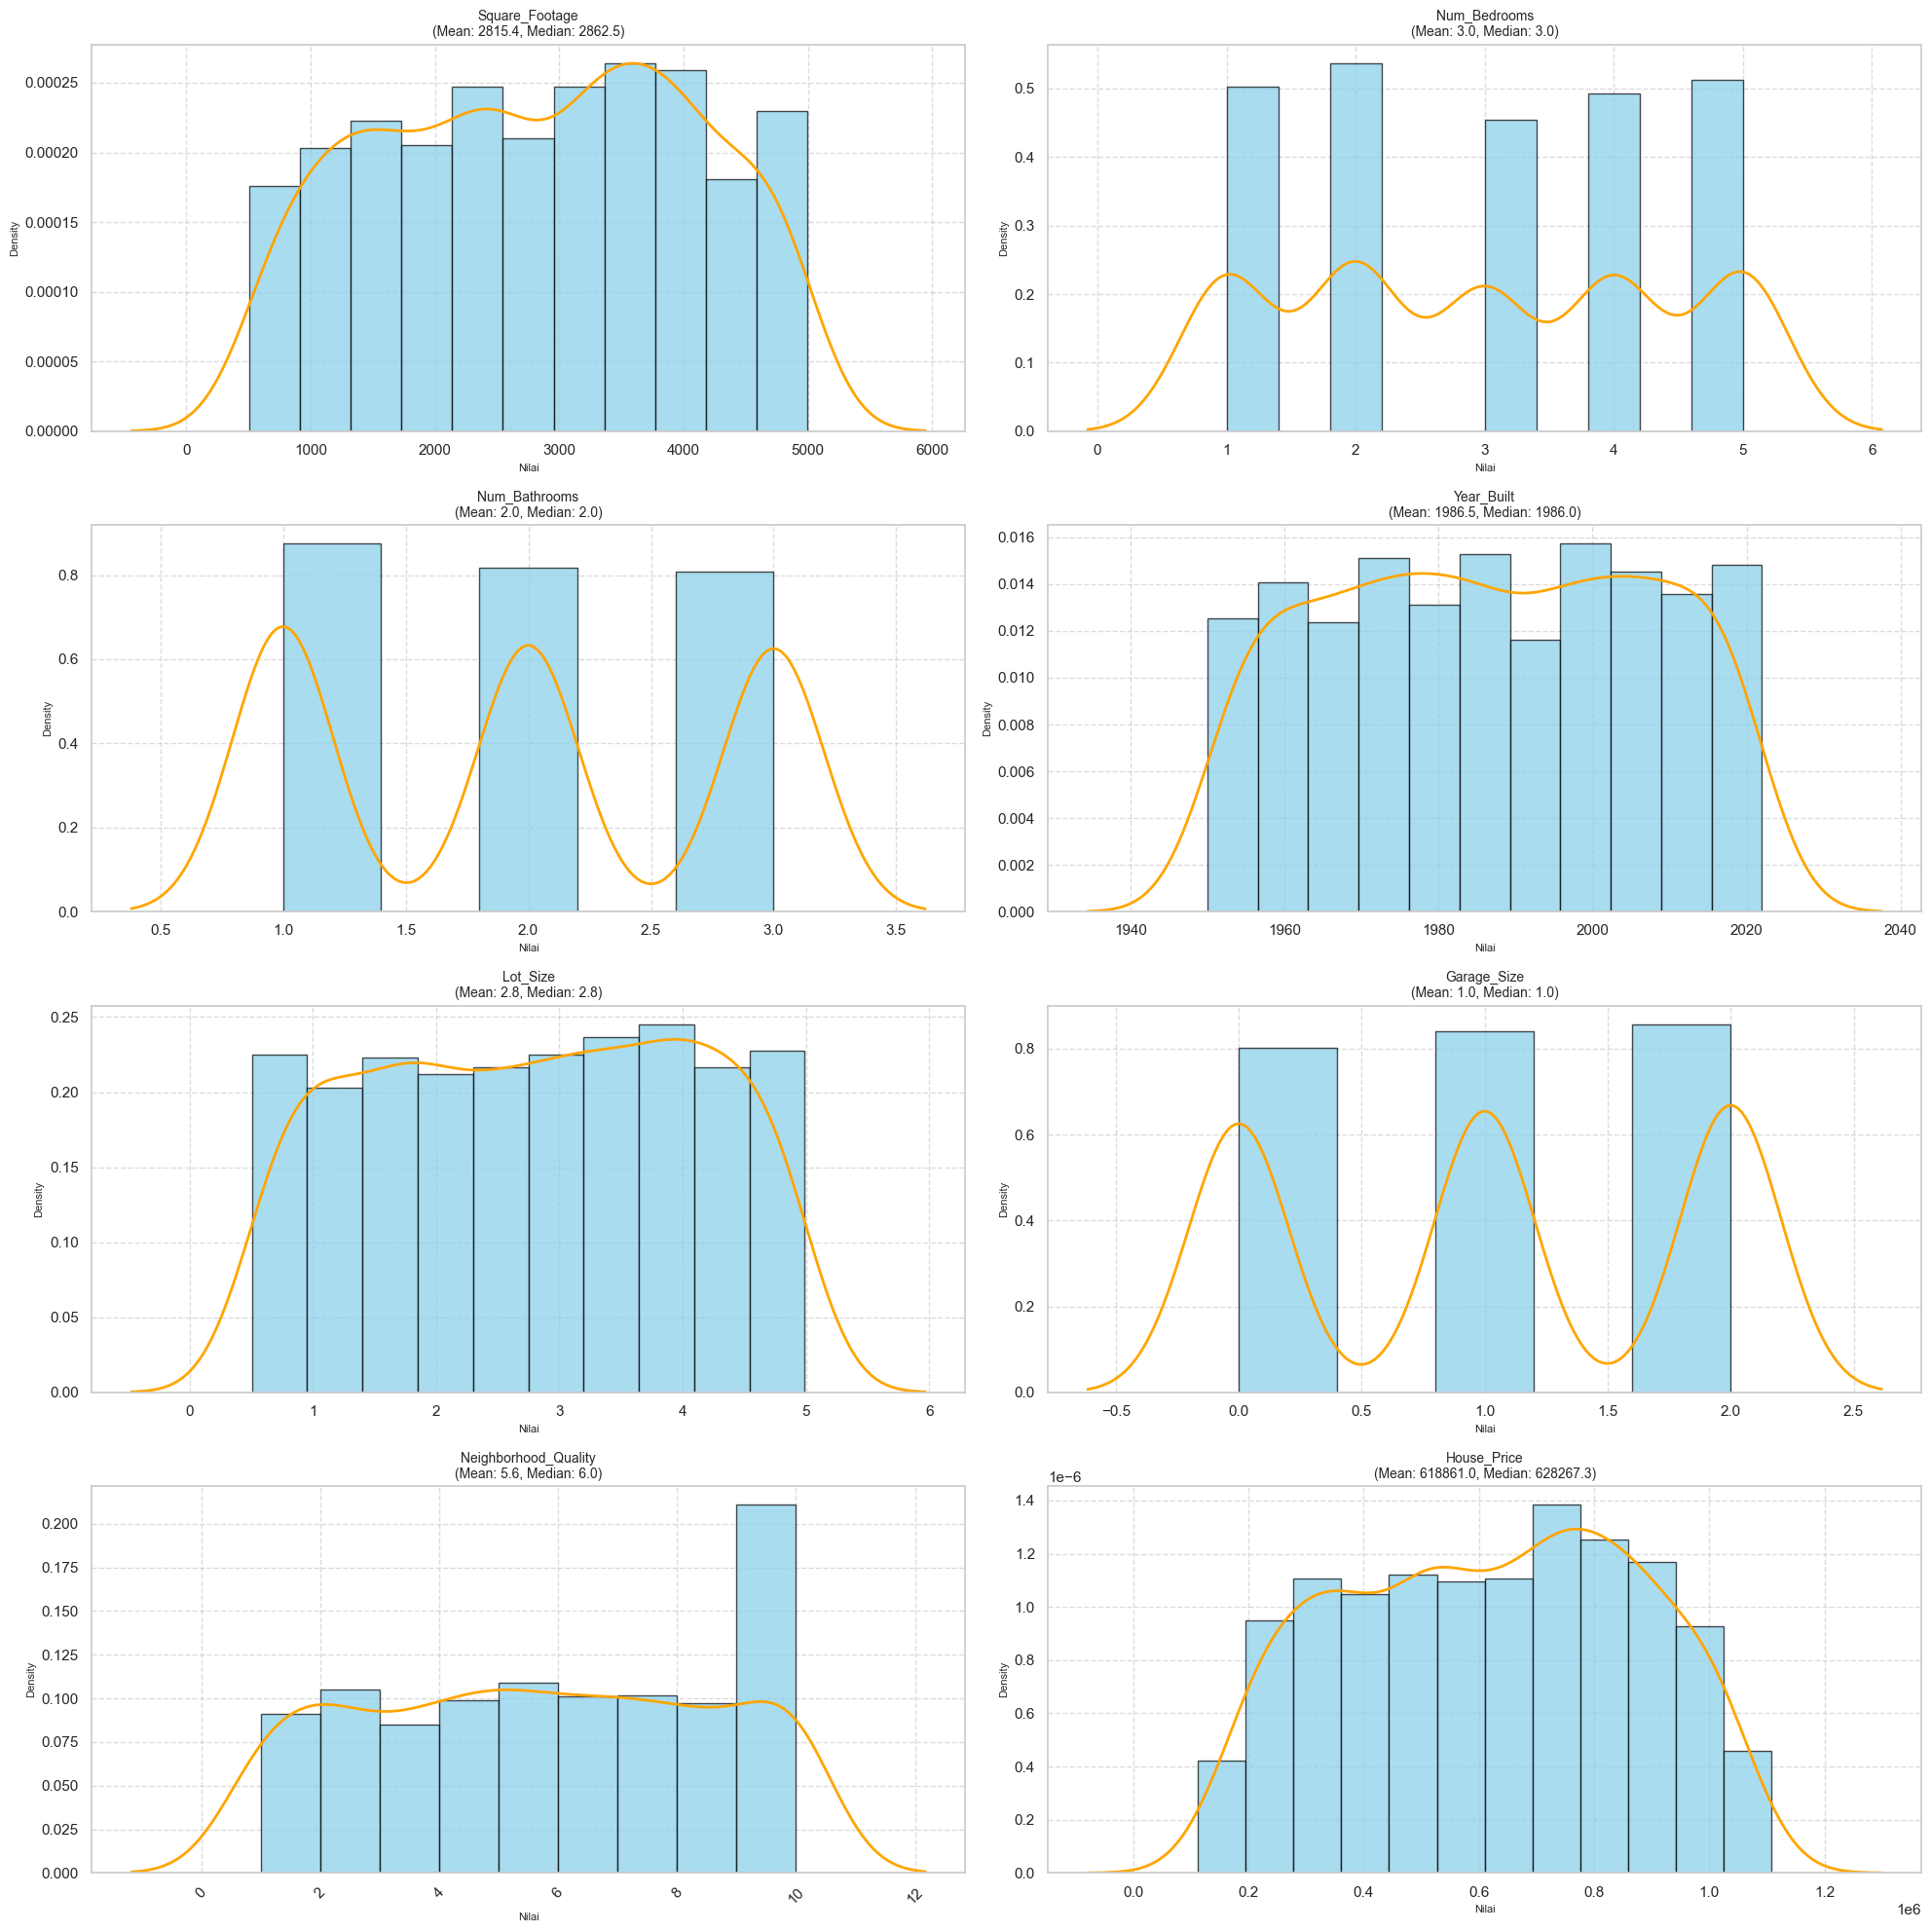

In [41]:
sns.set_theme(style='whitegrid')
numerical_cols = df_r.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df_r[col].dropna()
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    bin_width = (2 * iqr) / (len(data) ** (1/3))
    bin_count = int(np.ceil((data.max() - data.min()) / bin_width)) if iqr > 0 else 50
    
    axis.hist(
        data, 
        bins=min(bin_count, 50),  
        color='skyblue', 
        edgecolor='black',
        alpha=0.7,
        density=True  
    )
    
    sns.kdeplot(data, ax=axis, color='orange', linewidth=2)
    
    axis.set_title(f'{col}\n(Mean: {data.mean():.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_xlabel('Nilai', fontsize=8)
    axis.set_ylabel('Density', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    if len(col) > 15:
        axis.tick_params(axis='x', rotation=45)

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

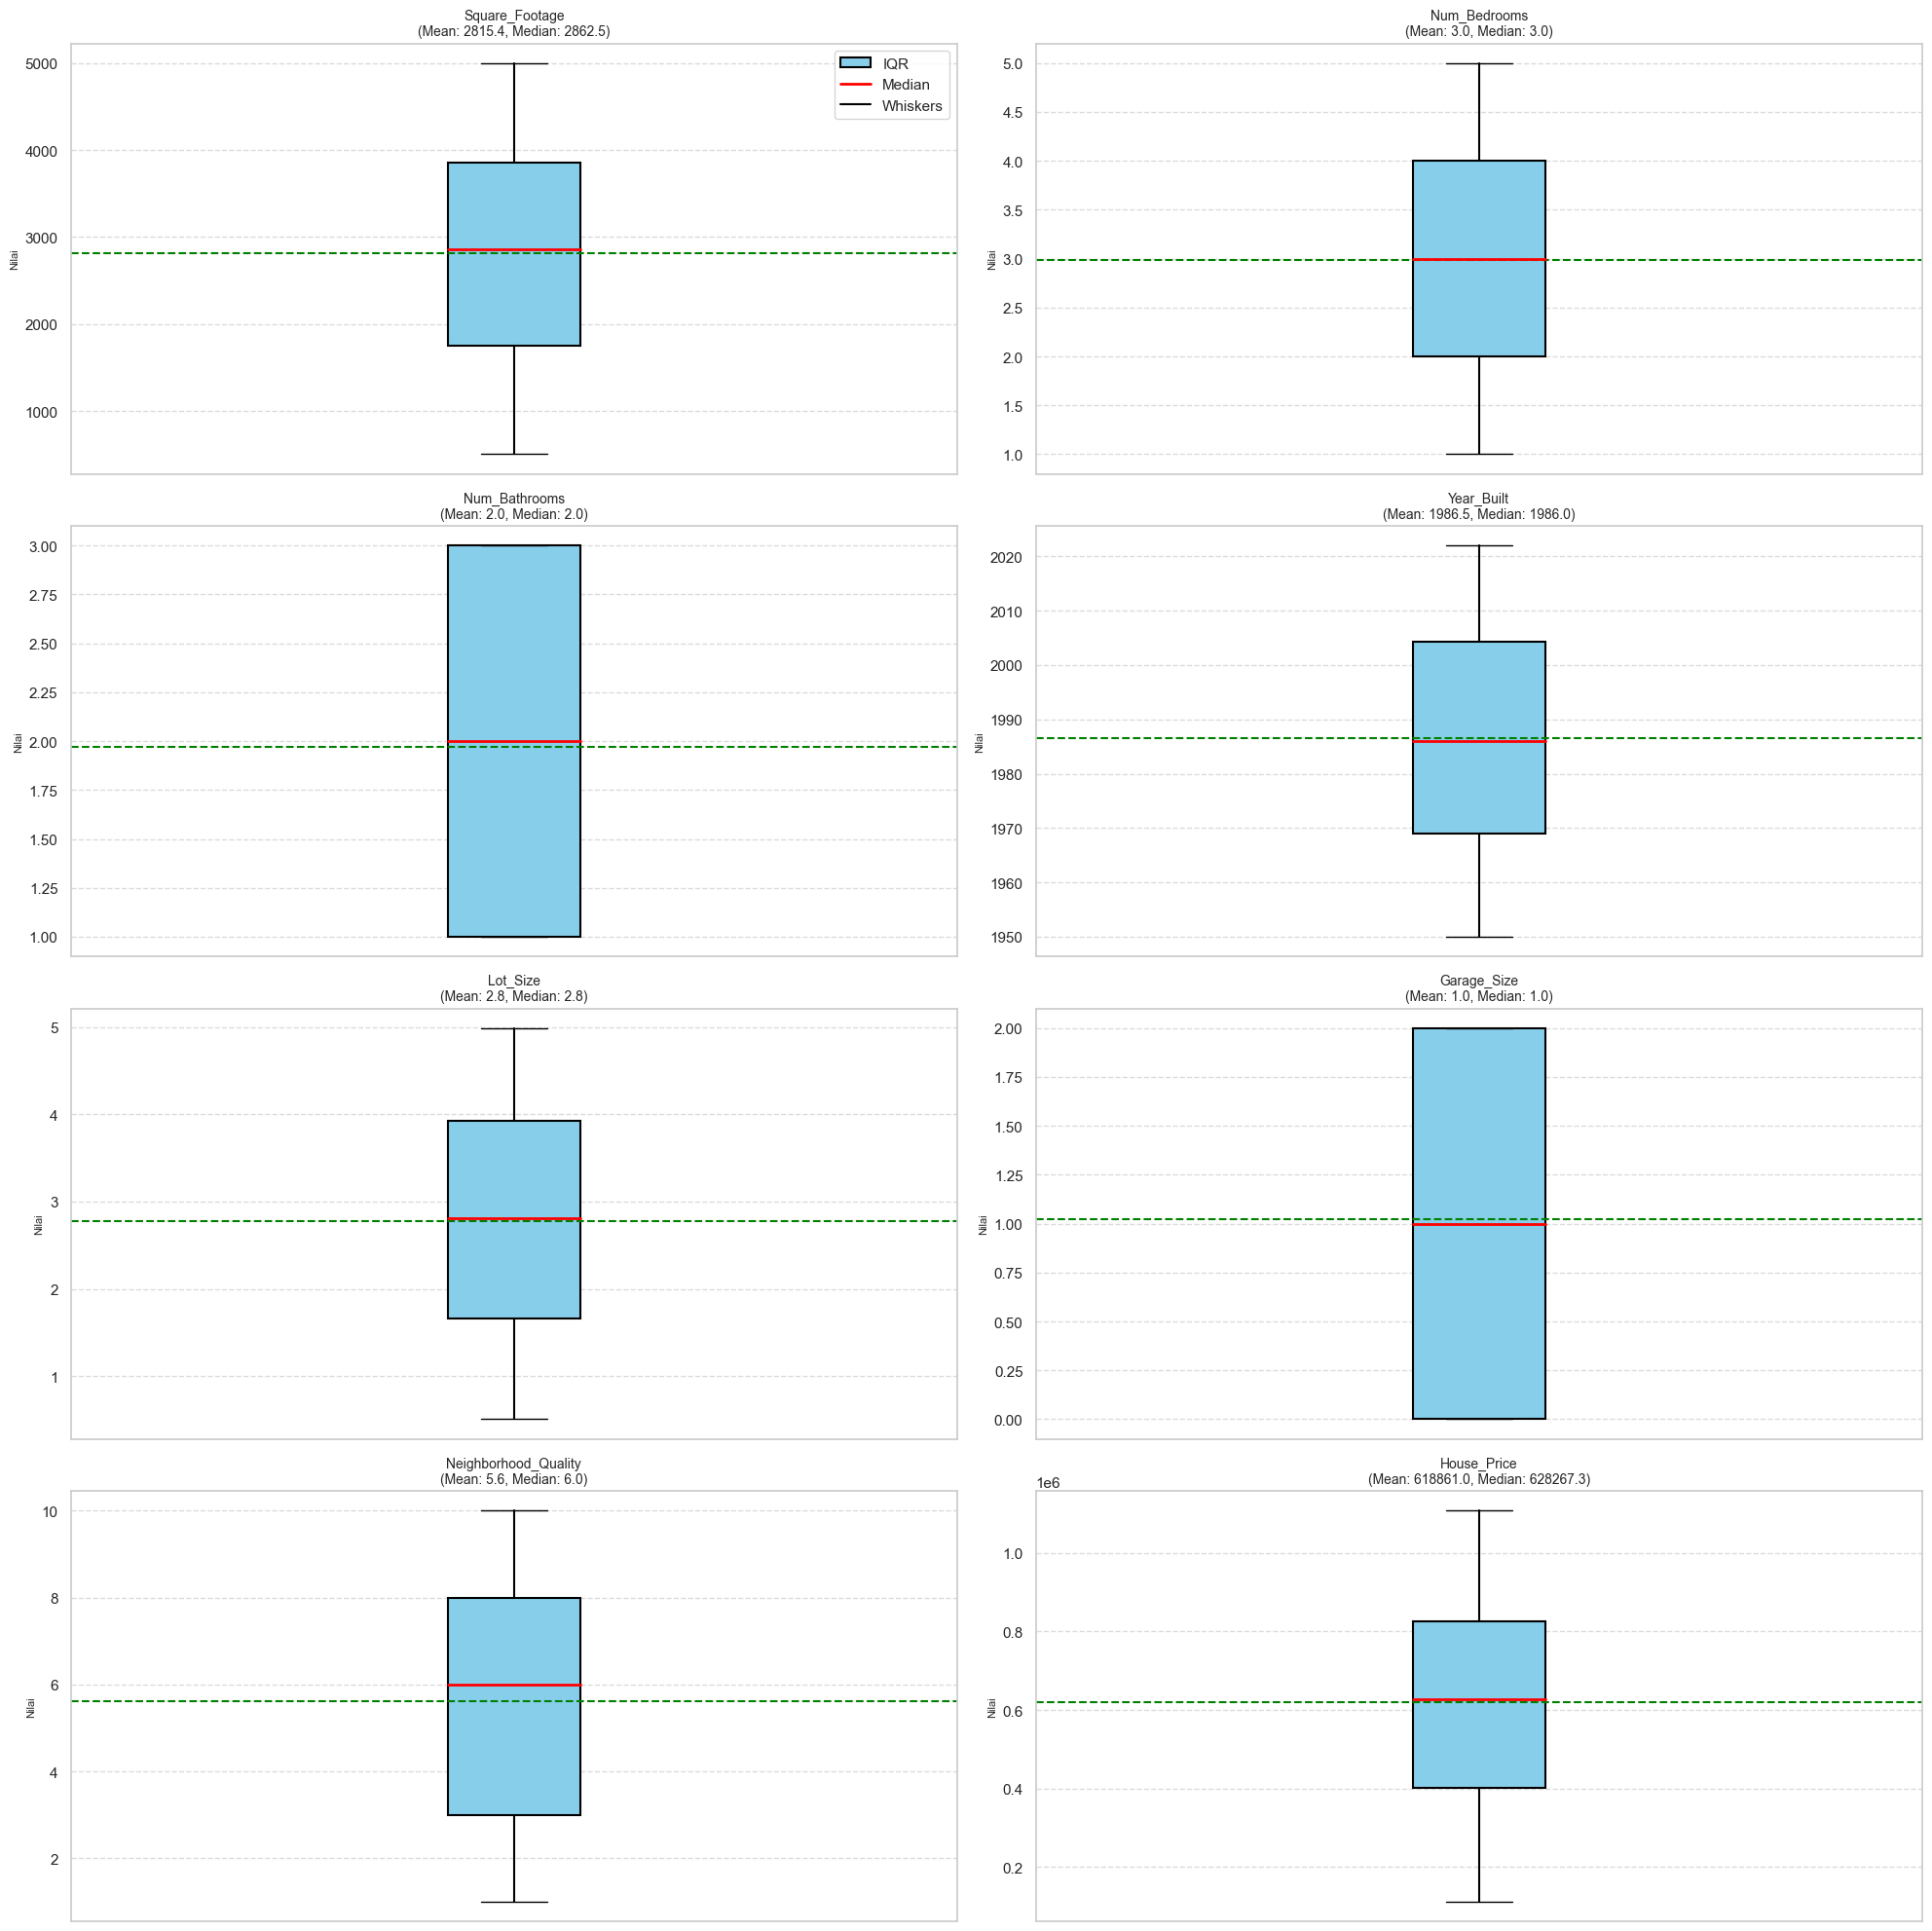

In [42]:
sns.set_theme(style='whitegrid')
numerical_cols = df_r.select_dtypes(include='number').columns.tolist()
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

boxprops = dict(facecolor='skyblue', linewidth=1.5)
whiskerprops = dict(color='black', linewidth=1.5)
medianprops = dict(color='red', linewidth=2)

for i, col in enumerate(numerical_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axis = ax[row, col_idx] if n_rows > 1 else ax[col_idx]
    
    data = df_r[col].dropna()
    
    bp = axis.boxplot(data,
                      vert=True,
                      patch_artist=True,
                      boxprops=boxprops,
                      whiskerprops=whiskerprops,
                      medianprops=medianprops,
                      flierprops=dict(marker='o', markersize=4))
    
    mean_val = data.mean()
    axis.axhline(mean_val, color='green', linestyle='--', linewidth=1.5)
    
    axis.set_title(f'{col}\n(Mean: {mean_val:.1f}, Median: {data.median():.1f})', fontsize=10)
    axis.set_ylabel('Nilai', fontsize=8)
    axis.grid(True, linestyle='--', alpha=0.7)
    
    axis.set_xticks([])
    
    if i == 0:  
        axis.legend([bp['boxes'][0], bp['medians'][0], bp['whiskers'][0]], 
                   ['IQR', 'Median', 'Whiskers'],
                   loc='upper right')

for j in range(i+1, n_rows*n_cols):
    row = j // n_cols
    col_idx = j % n_cols
    if n_rows > 1:
        ax[row, col_idx].axis('off')
    else:
        ax[col_idx].axis('off')

plt.tight_layout()
plt.show()

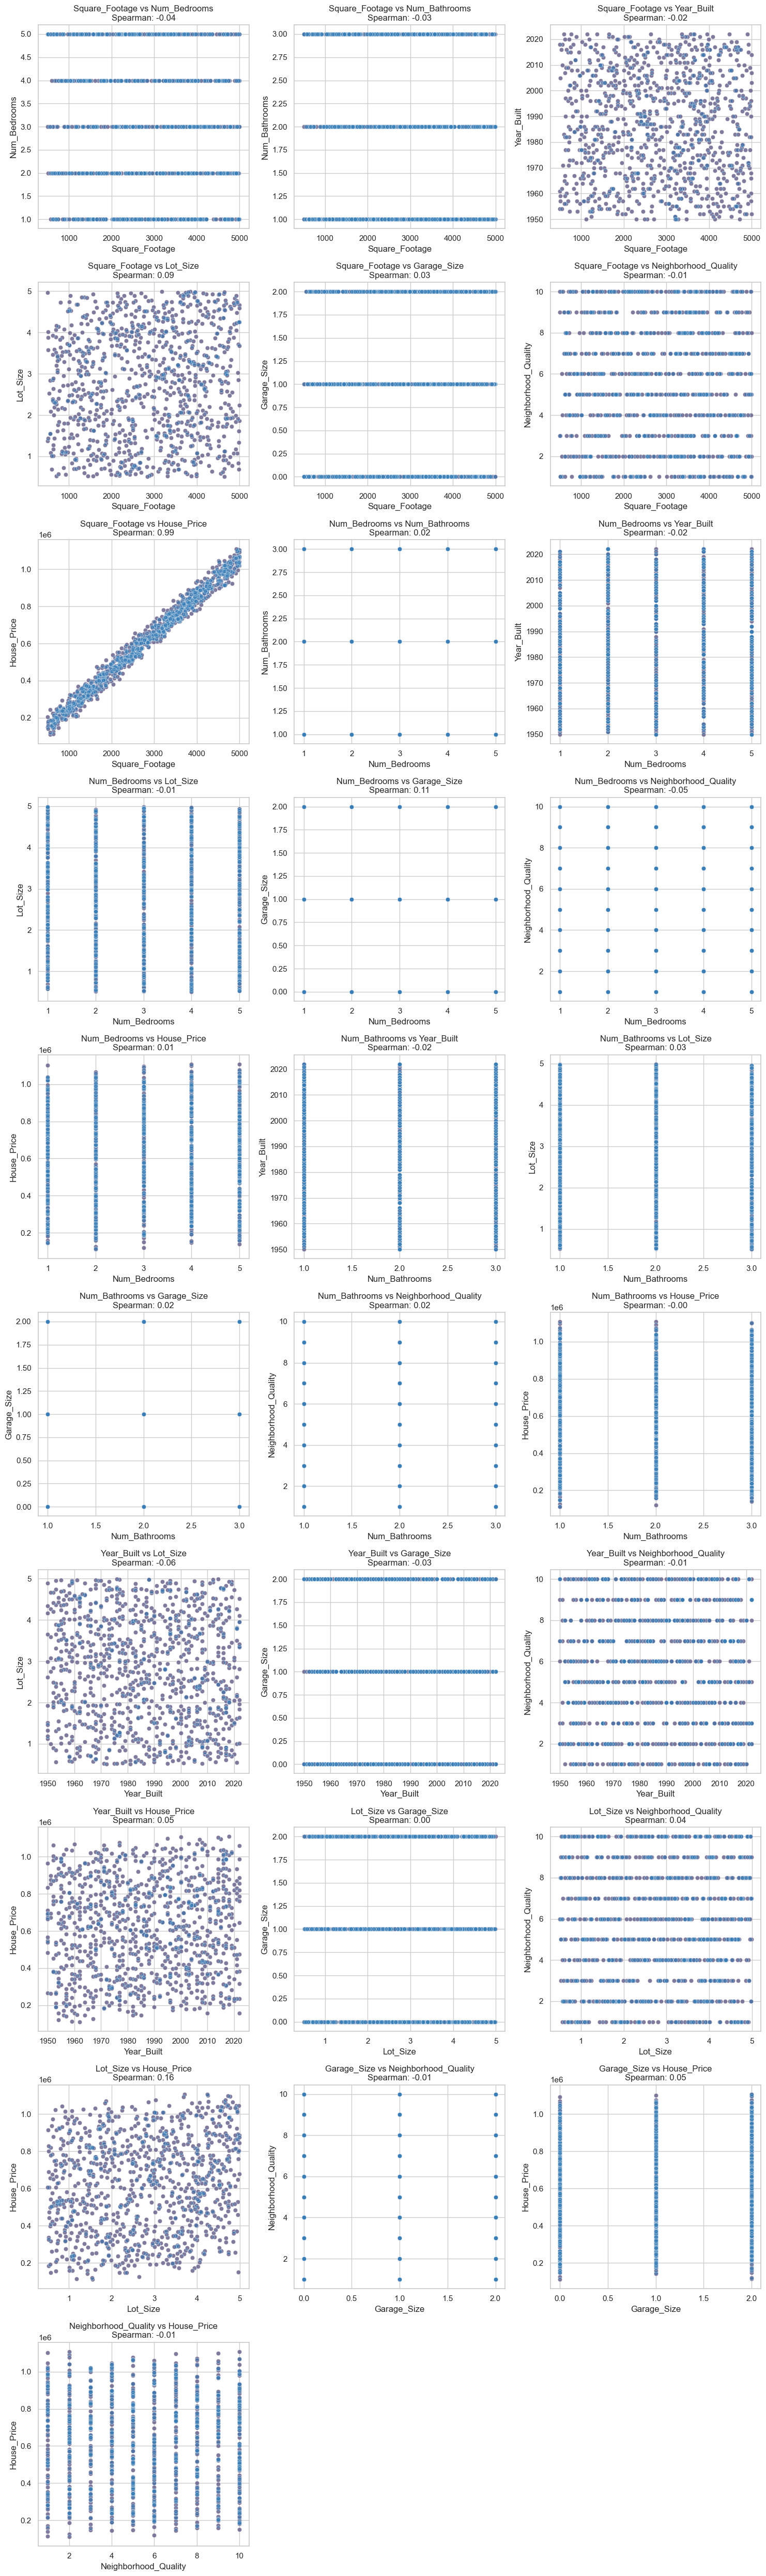

In [45]:
num_cols = df_r.select_dtypes(include='number').columns.tolist()
spearman_corr = df_r[num_cols].corr(method='spearman')
comb = list(combinations(num_cols, 2))

n_comb = len(comb)
rows = int(np.ceil(n_comb / 3))
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

colors = sns.color_palette("Set1", 2)

for i, (col_x, col_y) in enumerate(comb):
    ax = axes[i]
    sns.scatterplot(x=df_r[col_x], y=df_r[col_y], ax=ax, alpha=0.6, color=colors[0])
    sns.scatterplot(x=df_r[col_x], y=df_r[col_y], ax=ax, alpha=0.6, color=colors[1])
    rho = spearman_corr.loc[col_x, col_y]
    ax.set_title(f"{col_x} vs {col_y}\nSpearman: {rho:.2f}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [46]:
df_r.head()

Square_Footage  Num_Bedrooms  Num_Bathrooms  Year_Built  Lot_Size  \
0            1360             2              1        1981  0.599637   
1            4272             3              3        2016  4.753014   
2            3592             1              2        2016  3.634823   
3             966             1              2        1977  2.730667   
4            4926             2              1        1993  4.699073   

   Garage_Size  Neighborhood_Quality   House_Price  
0            0                     5  2.623829e+05  
1            1                     6  9.852609e+05  
2            0                     9  7.779774e+05  
3            1                     8  2.296989e+05  
4            0                     8  1.041741e+06

In [47]:
x_r = df_r.drop(columns=['House_Price'])
y_r = df_r['House_Price']

In [48]:
mm = MinMaxScaler()

x_r = pd.DataFrame(mm.fit_transform(x_r), columns=x_r.columns)
x_r.describe()

Square_Footage  Num_Bedrooms  Num_Bathrooms   Year_Built     Lot_Size  \
count     1000.000000   1000.000000    1000.000000  1000.000000  1000.000000   
mean         0.514329      0.497500       0.486500     0.507639     0.506782   
std          0.279252      0.356891       0.410166     0.286568     0.289501   
min          0.000000      0.000000       0.000000     0.000000     0.000000   
25%          0.277246      0.250000       0.000000     0.263889     0.258716   
50%          0.524800      0.500000       0.500000     0.500000     0.513843   
75%          0.744328      0.750000       1.000000     0.753472     0.762229   
max          1.000000      1.000000       1.000000     1.000000     1.000000   

       Garage_Size  Neighborhood_Quality  
count  1000.000000           1000.000000  
mean      0.511000              0.512778  
std       0.407486              0.320784  
min       0.000000              0.000000  
25%       0.000000              0.222222  
50%       0.500000              0.555556  
75%       1.000000              0.777778  
max       1.000000              1.000000

In [49]:
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_r, y_r, test_size=0.2, random_state=42)

## Modelling

In [51]:
automl_r = AutoML()
settings = {
    "time_budget" :10*60,
    "metric" : 'r2',
    "task" : 'regression',
    "log_file_name": "automl_regression.log"
}
automl_r.fit(X_train=x_train_r, y_train=y_train_r, **settings, verbose=0)


d:\Python\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
d:\Python\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of

In [55]:
y_pred_r = automl_r.predict(x_test_r)
r2 = r2_score(y_test_r, y_pred_r)
mse = mean_squared_error(y_test_r, y_pred_r)
print(f"r2: {r2}\nMSE: {mse}")

r2: 0.9970073184303267
MSE: 192904833.60411292


In [54]:
print(f"Best ML Learner: {automl_r.best_estimator}\nBest Config: {automl_r.best_config}")

Best ML Learner: xgb_limitdepth
Best Config: {'n_estimators': 346, 'max_depth': 2, 'min_child_weight': 3.3277426674811847, 'learning_rate': 0.18145169940316228, 'subsample': 1.0, 'colsample_bylevel': 0.9436418644522263, 'colsample_bytree': 1.0, 'reg_alpha': 0.043891499605249615, 'reg_lambda': 0.0009765625}
